# CenterNet


In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from ROI.centernet import CenterNet
from ROI.dataset import RoiDataset
from ROI.helpers import pool_duplicates, show_box
from ROI.losses import center_loss

In [2]:
# Hyper-params
MODEL_PATH = ''

input_size = 512
IN_SCALE = 512 // input_size
MODEL_SCALE = 4

batch_size = 2
model_name = 'resnet18'
TRAIN = True

In [ ]:
ORIGA_DIR = '../data/ORIGA'
IMAGES_DIR = f'{ORIGA_DIR}/Images_Square'
CSV_FILE = f'{ORIGA_DIR}/origa.csv'

df = pd.read_csv(CSV_FILE)

image_ids = df['image_id'].unique()
train_ids, test_ids = train_test_split(image_ids, test_size=0.2, random_state=411)

df.head()

In [8]:
train_dataset = RoiDataset(train_ids, df, input_size, IN_SCALE, MODEL_SCALE)
val_dataset = RoiDataset(test_ids, df, input_size, IN_SCALE, MODEL_SCALE)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CenterNet()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [14]:
#epochs=100
epochs = 10
logs = []
logs_eval = []

if TRAIN:
    for epoch in range(epochs):
        print(f'Epochs {epoch + 1}/{epochs} ')
        model.train()

        running_loss = 0.0
        running_mask = 0.0
        running_regr = 0.0

        pbar = tqdm(train_loader)
        for idx, (image, heatmap, regression) in enumerate(pbar):
            image = image.to(device)
            heatmap_gt = heatmap.to(device)
            regression_gt = regression.to(device)

            optimizer.zero_grad()
            heatmap, regression = model(image)
            preds = torch.cat((heatmap, regression), dim=1)

            loss, mask_loss, regr_loss = center_loss(preds, heatmap_gt, regression_gt)

            running_loss += loss
            running_mask += mask_loss
            running_regr += regr_loss

            loss.backward()
            optimizer.step()

            pbar.set_description(
                f'loss = {running_loss / (idx + 1):.3f}, '
                f'mask = {running_mask / (idx + 1):.4f}, '
                f'regr = {running_regr / (idx + 1):.4f}'
            )

        print(f'train loss : {running_loss / len(train_loader):.4f}')
        print(f'mask loss : {running_mask / len(train_loader):.4f}')
        print(f'regr loss : {running_regr / len(train_loader):.4f}')

        # save logs
        log_epoch = {
            'epoch': epoch + 1,
            'lr': optimizer.state_dict()['param_groups'][0]['lr'],
            'loss': running_loss / len(train_loader),
            'mask': running_mask / (len(train_loader)),
            'regr': running_regr / (len(train_loader)),
        }
        logs.append(log_epoch)
else:
    model.load_state_dict(torch.load(MODEL_PATH))

epochs 1/10 


C:\Users\ASUS\AppData\Local\Temp\ipykernel_23808\589172764.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/260 [00:00<?, ?it/s]

train loss : 78.7952
maskloss : 78.6127
regrloss : 0.1826
epochs 2/10 


  0%|          | 0/260 [00:00<?, ?it/s]

train loss : 7.1872
maskloss : 7.0532
regrloss : 0.1340
epochs 3/10 


  0%|          | 0/260 [00:00<?, ?it/s]

train loss : 4.1971
maskloss : 4.0734
regrloss : 0.1237
epochs 4/10 


  0%|          | 0/260 [00:00<?, ?it/s]

train loss : 2.7562
maskloss : 2.6527
regrloss : 0.1035
epochs 5/10 


  0%|          | 0/260 [00:00<?, ?it/s]

train loss : 1.8850
maskloss : 1.7990
regrloss : 0.0861
epochs 6/10 


  0%|          | 0/260 [00:00<?, ?it/s]

train loss : 1.3597
maskloss : 1.2838
regrloss : 0.0759
epochs 7/10 


  0%|          | 0/260 [00:00<?, ?it/s]

train loss : 1.0398
maskloss : 0.9709
regrloss : 0.0688
epochs 8/10 


  0%|          | 0/260 [00:00<?, ?it/s]

train loss : 0.8070
maskloss : 0.7431
regrloss : 0.0638
epochs 9/10 


  0%|          | 0/260 [00:00<?, ?it/s]

train loss : 0.6813
maskloss : 0.6176
regrloss : 0.0636
epochs 10/10 


  0%|          | 0/260 [00:00<?, ?it/s]

train loss : 0.5706
maskloss : 0.5068
regrloss : 0.0637


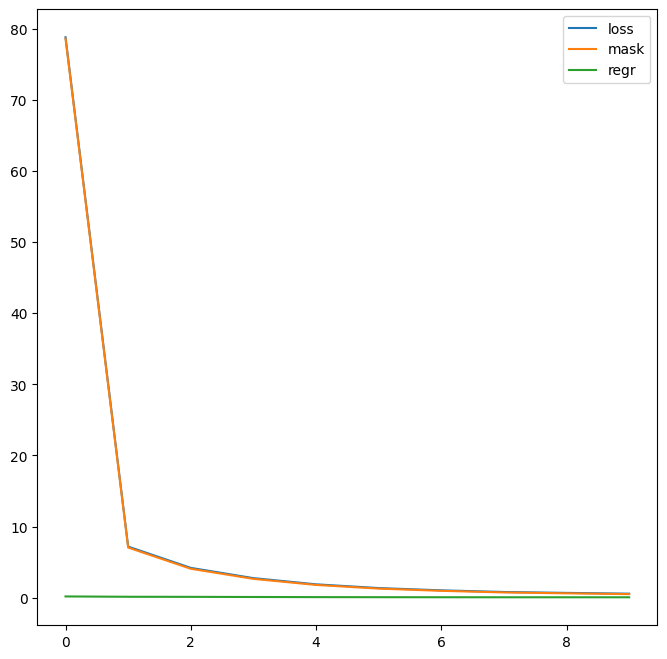

In [23]:
loss = [log['loss'].detach().cpu().numpy() for log in logs]
mask_loss = [log['mask'].detach().cpu().numpy() for log in logs]
regr_loss = [log['regr'].detach().cpu().numpy() for log in logs]

plt.figure(figsize=(8, 8))
plt.plot(loss, label='loss')
plt.plot(mask_loss, label='mask')
plt.plot(regr_loss, label='regr')
plt.legend()
plt.show()

# Show predictions

preds: (1, 4)
GT boxes: (1, 4)


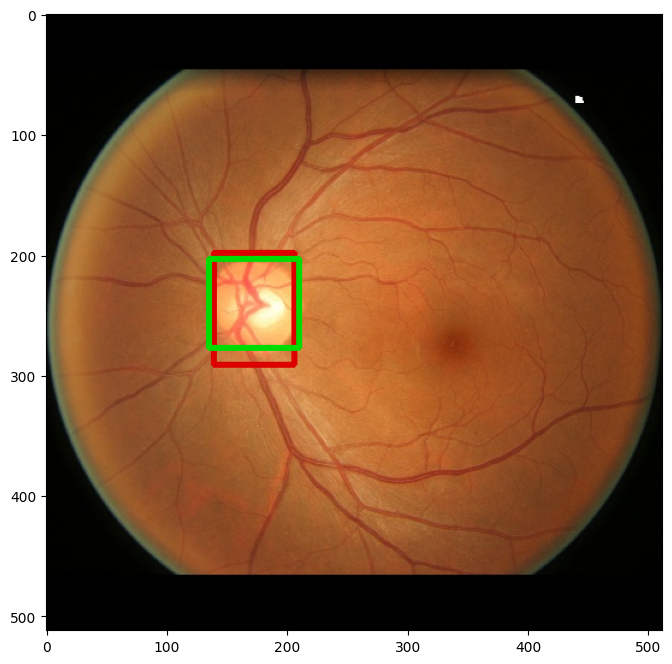

preds: (2, 4)
GT boxes: (1, 4)


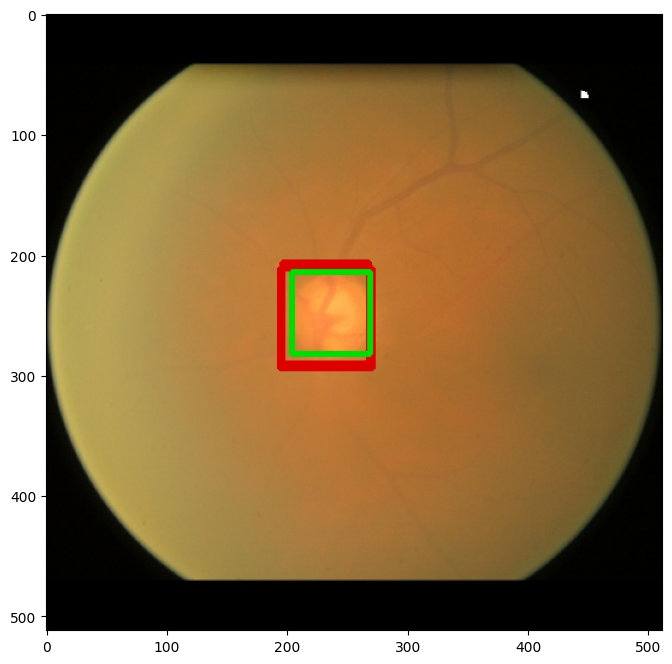

preds: (4, 4)
GT boxes: (1, 4)


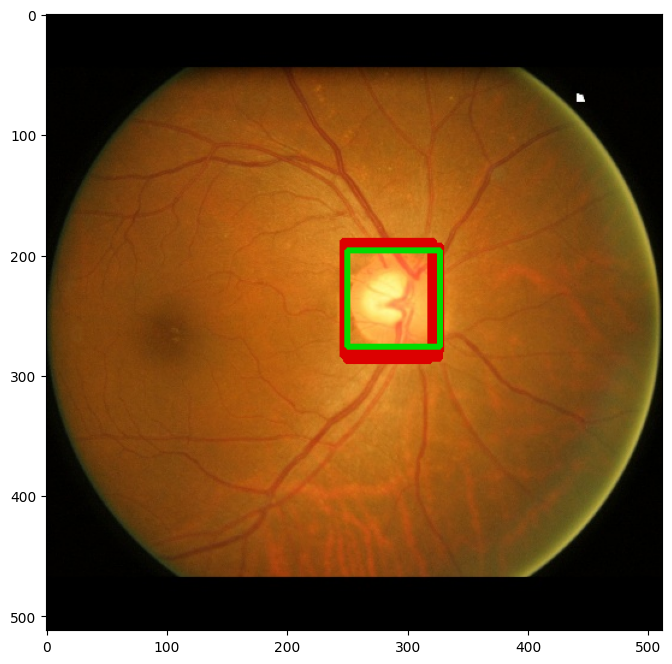

preds: (3, 4)
GT boxes: (1, 4)


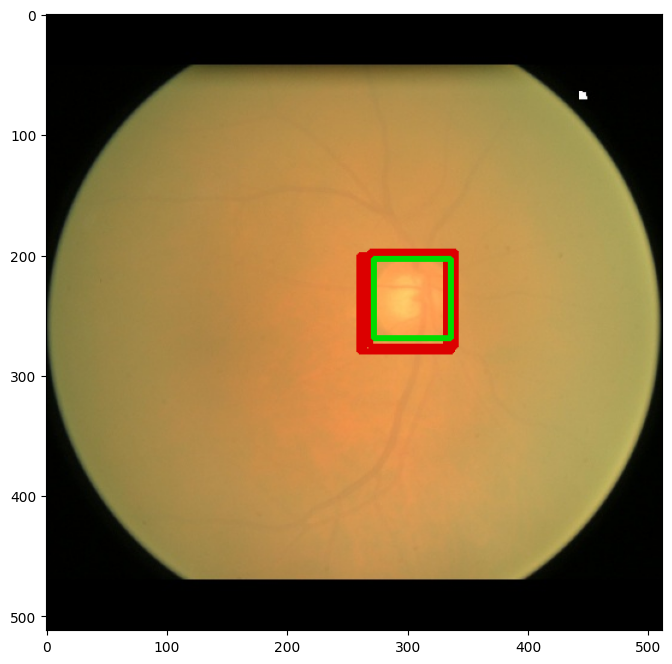

preds: (1, 4)
GT boxes: (1, 4)


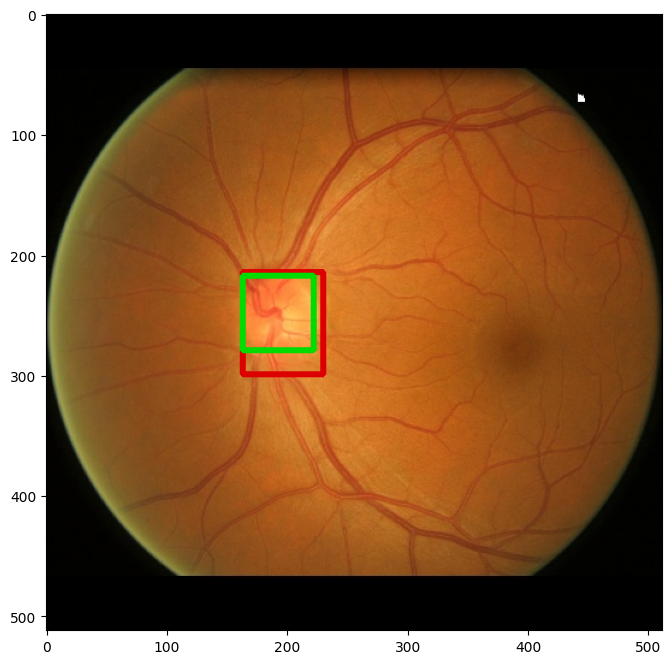

preds: (1, 4)
GT boxes: (1, 4)


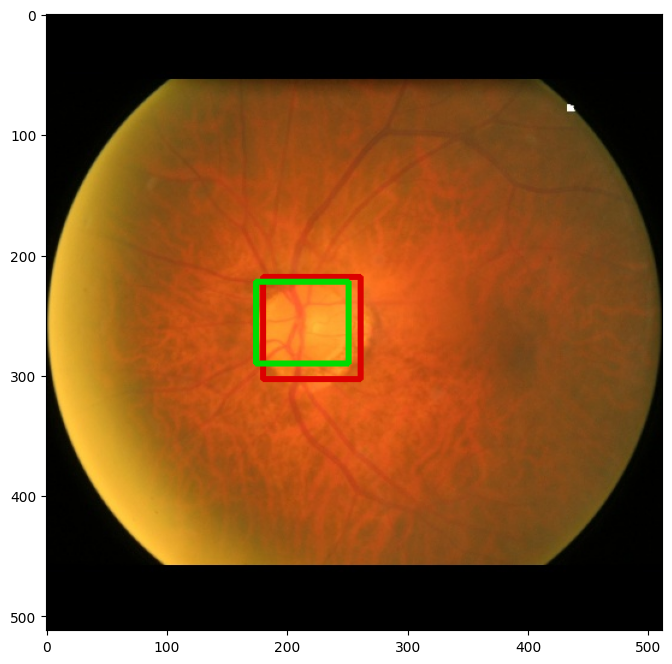

preds: (2, 4)
GT boxes: (1, 4)


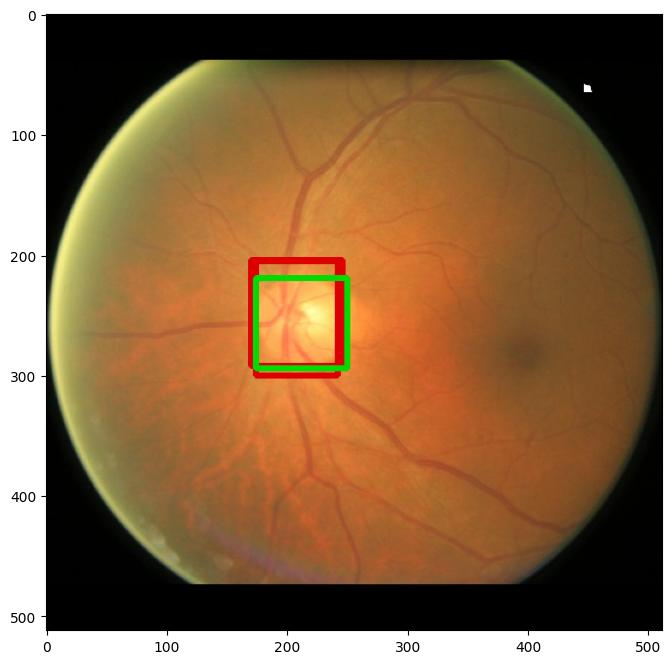

preds: (2, 4)
GT boxes: (1, 4)


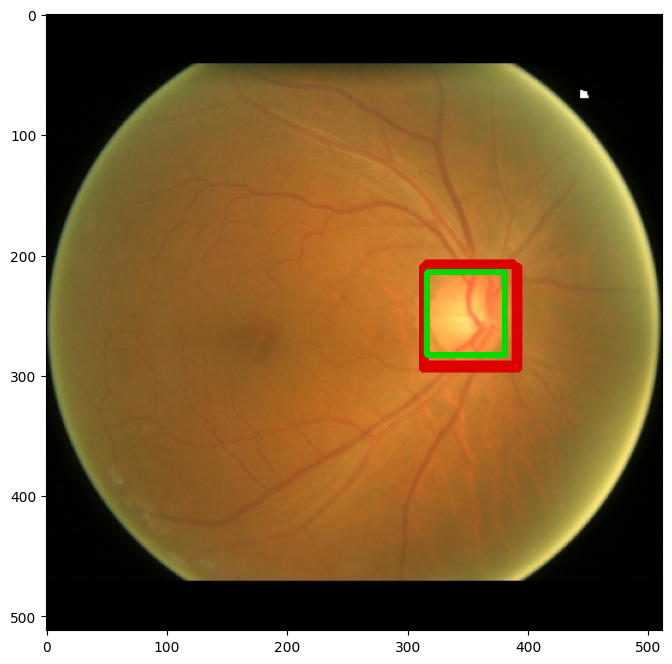

preds: (2, 4)
GT boxes: (1, 4)


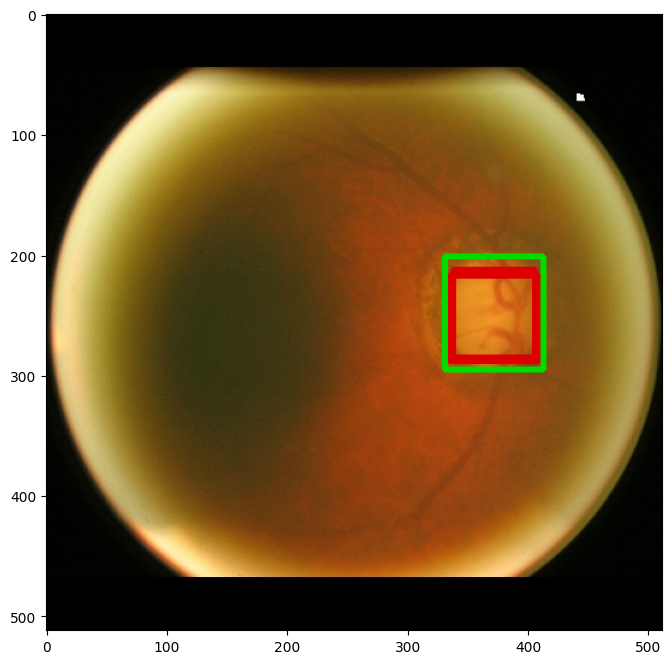

preds: (2, 4)
GT boxes: (1, 4)


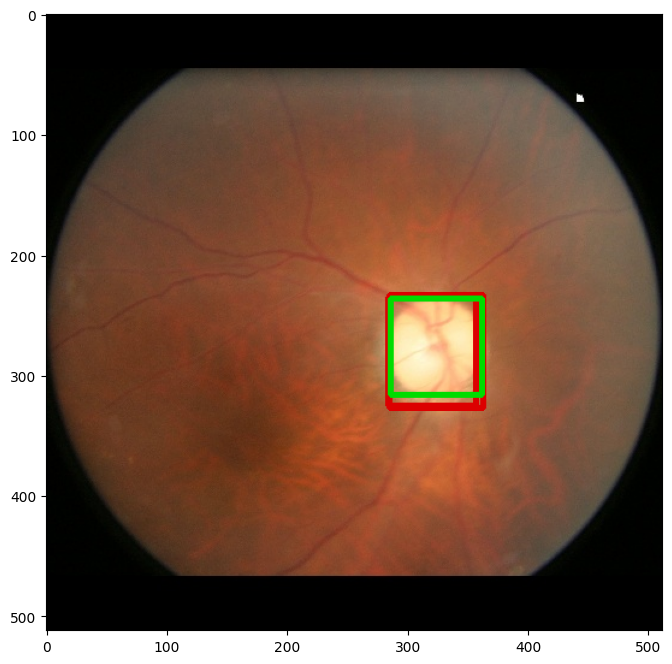

In [16]:
for _id in range(10):
    img, hm_gt, regr_gt = val_dataset[_id]
    img = torch.from_numpy(img)
    with torch.no_grad():
        hm, regr = model(img.to(device).float().unsqueeze(0))

    hm = hm.cpu().numpy().squeeze(0).squeeze(0)
    regr = regr.cpu().numpy().squeeze(0)

    # show image
    img_id = test_ids[_id]
    img = cv.imread(img_id)
    img = cv.resize(cv.cvtColor(img, cv.COLOR_BGR2RGB), (input_size, input_size))

    # get boxes
    hm = torch.sigmoid(torch.from_numpy(hm)).numpy()
    hm = pool_duplicates(hm)

    sample = show_box(img, hm, regr, input_size, MODEL_SCALE, 0.6, (0, 0, 220))
    sample = show_box(sample, hm_gt, regr_gt, input_size, MODEL_SCALE, 0.99)

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    plt.imshow(sample)
    plt.show()